In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401  (needed for 3D projection)
from pathlib import Path

from sklearn.decomposition import PCA
import umap

plt.rcdefaults()

In [ ]:
# This run is from the "associate_small.json" config
RUNS_PATH = Path('./runs/associate_manifold/20251206-113742/')
TRIAL     = 'trial_000.npz'

data = np.load(RUNS_PATH / TRIAL, allow_pickle=True)

# If record_dense = True, then:
# - The following are the binary neural activity matrices for the 3 brain regions
# - Shape of each is (T, N), where T = # timesteps, N = # neurons in region
A_dense = data["A_dense"]
B_dense = data["B_dense"]
C_dense = data["C_dense"]

# Get labels for each region (what action occured at each timestemp)
A_stages = np.array(data["A_stages"], dtype = str)
B_stages = np.array(data["B_stages"], dtype = str)
C_stages = np.array(data["C_stages"], dtype = str)

In [28]:
import numpy as np

def coarse_stage_label(stage: str) -> str:
    """Map fine-grained protocol stages to coarse phases."""
    if stage == "init_pair" or stage.startswith("stabilize_"):
        return "stabilize"

    if stage == "seed_A_to_C" or stage.startswith("A_to_C_recur_"):
        return "A_to_C"

    if stage == "seed_B_to_C" or stage.startswith("B_to_C_recur_"):
        return "B_to_C"

    if stage == "joint_seed" or stage.startswith("joint_assoc_"):
        return "joint"

    if stage == "post_B_seed" or stage.startswith("post_B_recur_"):
        return "post_B"

    # Fallback (should not be hit with your current stages, but safe to have)
    return "other"

# Make coarse versions of the stages
A_phases = np.array([coarse_stage_label(s) for s in A_stages], dtype = str)
B_phases = np.array([coarse_stage_label(s) for s in B_stages], dtype = str)
C_phases = np.array([coarse_stage_label(s) for s in C_stages], dtype = str)

In [37]:
def compute_embedding(X: np.ndarray, method: str = "umap", n_components: int = 2, random_state: int = 0):
    """
    Compute a low-dimensional embedding of X.

    Parameters
    ----------
    X : array, shape (n_samples, n_features)
        Population activity matrix (here: C_dense).
    method : {"umap", "pca"}
        Embedding method to use.
    n_components : int
        Target dimensionality.
    random_state : int
        RNG seed for reproducible embeddings.

    Returns
    -------
    embedding : np.ndarray, shape (n_samples, n_components)
    model : fitted embedding object (PCA or UMAP)
    """
    if method == "pca":
        model = PCA(n_components = n_components, random_state = random_state)
    elif method == "umap":
        if umap is None:
            raise ImportError("umap-learn is not installed. Use method='pca' or install umap-learn.")
        model = umap.UMAP(n_components = n_components, random_state = random_state)
    else:
        raise ValueError("method must be 'pca' or 'umap'.")

    embedding = model.fit_transform(X)
    return embedding, model

embedding_A, _ = compute_embedding(A_dense, method="umap", n_components = 3)
embedding_B, _ = compute_embedding(B_dense, method="umap", n_components = 3)
embedding_C, _ = compute_embedding(C_dense, method="umap", n_components = 3)

/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


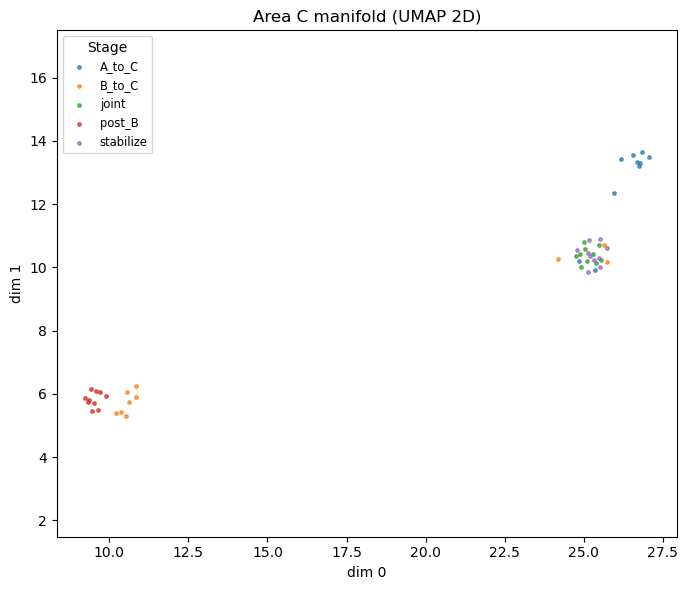

In [39]:
def plot_embedding_by_stage(
    embedding: np.ndarray,
    stages: np.ndarray,
    mode: str = "2d",
    dims: tuple[int, ...] | None = None,
    title: str | None = None,
    figsize: tuple[float, float] = (7.0, 6.0),
    point_size: float = 6.0,
    alpha: float = 0.7,
    max_legend_entries: int = 15,
):
    """
    Plot a 2D or 3D embedding of neural activity, colored by stage label.

    Parameters
    ----------
    embedding : array, shape (n_samples, d_embed)
        Embedding coordinates.
    stages : array-like, shape (n_samples,)
        Stage labels (strings) aligned with rows of `embedding`.
    mode : {"2d", "3d"}
        Whether to make a 2D or 3D scatter.
    dims : tuple of ints, optional
        Which embedding dimensions to plot.
        - For mode="2d": (i, j)
        - For mode="3d": (i, j, k)
        If None, uses (0,1) or (0,1,2) by default.
    title : str or None
        Figure title; if None, a default is used.
    figsize : (width, height)
        Figure size in inches.
    point_size : float
        Marker size for scatter.
    alpha : float
        Point transparency.
    max_legend_entries : int
        Maximum number of distinct stages to show in legend.
    """
    embedding = np.asarray(embedding)
    stages = np.asarray(stages, dtype=str)

    d_embed = embedding.shape[1]
    if mode not in {"2d", "3d"}:
        raise ValueError("mode must be '2d' or '3d'.")

    if dims is None:
        dims = (0, 1) if mode == "2d" else (0, 1, 2)

    if mode == "2d" and len(dims) != 2:
        raise ValueError("For mode='2d', dims must have length 2.")
    if mode == "3d" and len(dims) != 3:
        raise ValueError("For mode='3d', dims must have length 3.")

    if max(dims) >= d_embed:
        raise ValueError(
            f"Embedding has only {d_embed} dims, but dims={dims} was requested."
        )

    unique_stages = np.unique(stages)
    n_stages = len(unique_stages)

    cmap = plt.get_cmap("tab10" if n_stages <= 20 else "gist_ncar")

    fig = plt.figure(figsize=figsize)

    if mode == "2d":
        ax = fig.add_subplot(111)
        xdim, ydim = dims
    else:
        ax = fig.add_subplot(111, projection="3d")
        xdim, ydim, zdim = dims

    for idx, stage in enumerate(unique_stages):
        mask = stages == stage
        color = cmap(idx % cmap.N)
        label = stage if idx < max_legend_entries else None

        x = embedding[mask, dims[0]]
        y = embedding[mask, dims[1]]

        if mode == "2d":
            ax.scatter(x, y, s=point_size, alpha=alpha, color=color, label=label)
        else:
            z = embedding[mask, dims[2]]
            ax.scatter(x, y, z, s=point_size, alpha=alpha, color=color, label=label)

    ax.set_xlabel(f"dim {dims[0]}")
    ax.set_ylabel(f"dim {dims[1]}")
    if mode == "3d":
        ax.set_zlabel(f"dim {dims[2]}")

    if title is None:
        title = f"Embedding ({mode.upper()}) colored by stage"
    ax.set_title(title)

    if n_stages <= max_legend_entries:
        ax.legend(loc="best", fontsize="small", frameon=True, title="Stage")

    if mode == "2d":
        ax.set_aspect("equal", adjustable="datalim")

    fig.tight_layout()
    plt.show()


plot_embedding_by_stage(
    embedding_C,
    C_phases,
    mode  = "2d",
    title = "Area C manifold (UMAP 2D)"
)